### Video Classification using LSTM + Attention layer

In [153]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp 

import torch 
import torch.nn as nn
import torch.nn.functional as F

In [154]:
mp_holist = mp.solutions.holistic 
mp_draw = mp.solutions.drawing_utils

In [155]:
def mediapipe_detection(img, model):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img.flags.writeable = False                 
    result = model.process(img)                 # Make prediction
    img.flags.writeable = True                   
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
    return img, result

In [156]:
def draw_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS) # Draw face connections
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS) # Draw pose connections
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw left hand connections
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw right hand connections

In [157]:
def draw_styled_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
                             mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
                             mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
                             ) 
    # mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
    #                          mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
    #                          mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
    #                          ) 
    
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS,
                             mp_draw.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [158]:
def extract_keypoints(results):
    pose=np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    left_hnd=np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hnd=np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face=np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    return np.concatenate([pose,left_hnd,right_hnd,face])
# concatenating for the model to detect the sign language

In [159]:
import os 
video_dir = "C:/Users/araya/Desktop/keypoints/video_extract"
video_list = []
video_list = os.listdir(video_dir)

len(video_list)

40

In [160]:
video_list

['กฎกระทรวง.mp4',
 'กฎหมายรัฐธรรมนูญ.mp4',
 'กรมอนามัย.mp4',
 'กรรม.mp4',
 'กรรมสิทธิ์.mp4',
 'กระโดด.mp4',
 'กล้วยบวชชี.mp4',
 'กล้วยเชื่อม.mp4',
 'กังวล.mp4',
 'กีฬา.mp4',
 'น้อง.mp4',
 'เขิน.mp4',
 'เขื่อนดิน.mp4',
 'เขื่อนสิริกิติ์.mp4',
 'เข้าใจผิด.mp4',
 'เคย.mp4',
 'เครียด.mp4',
 'เครื่องปั่นดิน.mp4',
 'เครื่องหมายการค้า.mp4',
 'เจอ.mp4',
 'เจ้าหนี้.mp4',
 'เช่าซื้อ.mp4',
 'เช่าทรัพย์.mp4',
 'เซอร์เบีย.mp4',
 'เซเนกัล.mp4',
 'เซ็ง.mp4',
 'เดิน.mp4',
 'เดิมพัน.mp4',
 'เพลีย.mp4',
 'เมื่อย.mp4',
 'เม็กซิโก.mp4',
 'เฮโรอีน.mp4',
 'แกมเบีย.mp4',
 'แซมเบีย.mp4',
 'โกหก.mp4',
 'โจทก์.mp4',
 'โชจู.mp4',
 'ใกล้.mp4',
 'ไดโนเสาร์.mp4',
 'ไอซ์.mp4']

In [161]:
# Path for exported data, numpy arrays
Model_Data=os.path.join('Data for different actions')

actions = np.array(video_list)

no_of_seqs = 1

# 30 frames in length
seq_length = 160

In [162]:
actions

array(['กฎกระทรวง.mp4', 'กฎหมายรัฐธรรมนูญ.mp4', 'กรมอนามัย.mp4',
       'กรรม.mp4', 'กรรมสิทธิ์.mp4', 'กระโดด.mp4', 'กล้วยบวชชี.mp4',
       'กล้วยเชื่อม.mp4', 'กังวล.mp4', 'กีฬา.mp4', 'น้อง.mp4', 'เขิน.mp4',
       'เขื่อนดิน.mp4', 'เขื่อนสิริกิติ์.mp4', 'เข้าใจผิด.mp4', 'เคย.mp4',
       'เครียด.mp4', 'เครื่องปั่นดิน.mp4', 'เครื่องหมายการค้า.mp4',
       'เจอ.mp4', 'เจ้าหนี้.mp4', 'เช่าซื้อ.mp4', 'เช่าทรัพย์.mp4',
       'เซอร์เบีย.mp4', 'เซเนกัล.mp4', 'เซ็ง.mp4', 'เดิน.mp4',
       'เดิมพัน.mp4', 'เพลีย.mp4', 'เมื่อย.mp4', 'เม็กซิโก.mp4',
       'เฮโรอีน.mp4', 'แกมเบีย.mp4', 'แซมเบีย.mp4', 'โกหก.mp4',
       'โจทก์.mp4', 'โชจู.mp4', 'ใกล้.mp4', 'ไดโนเสาร์.mp4', 'ไอซ์.mp4'],
      dtype='<U21')

Collecting keypoint values for Training nd Testing

In [163]:
# Define the directory where your videos are stored
directory = "C:/Users/araya/Desktop/keypoints/video_extract"

In [164]:
directory

'C:/Users/araya/Desktop/keypoints/video_extract'

In [165]:
for filename in actions:
    print(directory + '/' + filename)

C:/Users/araya/Desktop/keypoints/video_extract/กฎกระทรวง.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กฎหมายรัฐธรรมนูญ.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรมอนามัย.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรรม.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรรมสิทธิ์.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กระโดด.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กล้วยบวชชี.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กล้วยเชื่อม.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กังวล.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กีฬา.mp4
C:/Users/araya/Desktop/keypoints/video_extract/น้อง.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขิน.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขื่อนดิน.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขื่อนสิริกิติ์.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เข้าใจผิด.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เคย.mp4
C:/Users/araya/Desktop/keypoints/video_e

In [166]:
file_paths = []
for action in actions:
    video_path = os.path.join('Data for different actions/', action)
    # print(video_path)
    # print(action)
    file_paths.append(video_path + '/' + action.split(".")[0] + ".npy")
print(file_paths)

['Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy', 'Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy', 'Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy', 'Data for different actions/กรรม.mp4/กรรม.npy', 'Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy', 'Data for different actions/กระโดด.mp4/กระโดด.npy', 'Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy', 'Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy', 'Data for different actions/กังวล.mp4/กังวล.npy', 'Data for different actions/กีฬา.mp4/กีฬา.npy', 'Data for different actions/น้อง.mp4/น้อง.npy', 'Data for different actions/เขิน.mp4/เขิน.npy', 'Data for different actions/เขื่อนดิน.mp4/เขื่อนดิน.npy', 'Data for different actions/เขื่อนสิริกิติ์.mp4/เขื่อนสิริกิติ์.npy', 'Data for different actions/เข้าใจผิด.mp4/เข้าใจผิด.npy', 'Data for different actions/เคย.mp4/เคย.npy', 'Data for different actions/เครียด.mp4/เครียด.npy', 'Data for different actions/เครื่องปั่นดิน.mp4/เครื

In [167]:
def load_keypoint_sequences(file_paths):
    keypoint_sequences = []
    for file_path in file_paths:
        keypoints = np.load(file_path)
        keypoint_sequences.append(torch.tensor(keypoints, dtype=torch.float32))
    return keypoint_sequences

In [168]:
# Load the sequences
import torch
sequences = load_keypoint_sequences(file_paths)
sequences

[tensor([[ 0.5013,  0.2452, -1.2167,  ...,  0.5663,  0.2188,  0.0098],
         [ 0.4997,  0.2482, -1.4690,  ...,  0.5652,  0.2181,  0.0106],
         [ 0.4984,  0.2500, -1.4853,  ...,  0.5654,  0.2185,  0.0112],
         ...,
         [ 0.4861,  0.2513, -1.3416,  ...,  0.5572,  0.2177,  0.0091],
         [ 0.4873,  0.2514, -1.3574,  ...,  0.5575,  0.2172,  0.0097],
         [ 0.4883,  0.2516, -1.3579,  ...,  0.5577,  0.2170,  0.0101]]),
 tensor([[ 0.4922,  0.2382, -1.2850,  ...,  0.5578,  0.2124,  0.0094],
         [ 0.4920,  0.2405, -1.4288,  ...,  0.5571,  0.2116,  0.0099],
         [ 0.4920,  0.2409, -1.4093,  ...,  0.5567,  0.2122,  0.0098],
         ...,
         [ 0.4814,  0.2260, -1.3318,  ...,  0.5503,  0.1923,  0.0123],
         [ 0.4815,  0.2257, -1.3351,  ...,  0.5503,  0.1921,  0.0122],
         [ 0.4815,  0.2255, -1.3497,  ...,  0.5501,  0.1919,  0.0124]]),
 tensor([[ 0.5049,  0.2371, -1.2115,  ...,  0.5643,  0.2082,  0.0088],
         [ 0.5045,  0.2381, -1.1896,  ...,  0

In [169]:
# Pad the sequences to the same length
from torch.nn.utils.rnn import pad_sequence
padded_sequences = pad_sequence(sequences, batch_first=True)
pad_sequence
print(padded_sequences.shape) # (batch_size, max_sequence_length, num_keypoints)

torch.Size([40, 160, 1662])


In [170]:
labels = [action.split(".")[0] for action in actions]
labels

['กฎกระทรวง',
 'กฎหมายรัฐธรรมนูญ',
 'กรมอนามัย',
 'กรรม',
 'กรรมสิทธิ์',
 'กระโดด',
 'กล้วยบวชชี',
 'กล้วยเชื่อม',
 'กังวล',
 'กีฬา',
 'น้อง',
 'เขิน',
 'เขื่อนดิน',
 'เขื่อนสิริกิติ์',
 'เข้าใจผิด',
 'เคย',
 'เครียด',
 'เครื่องปั่นดิน',
 'เครื่องหมายการค้า',
 'เจอ',
 'เจ้าหนี้',
 'เช่าซื้อ',
 'เช่าทรัพย์',
 'เซอร์เบีย',
 'เซเนกัล',
 'เซ็ง',
 'เดิน',
 'เดิมพัน',
 'เพลีย',
 'เมื่อย',
 'เม็กซิโก',
 'เฮโรอีน',
 'แกมเบีย',
 'แซมเบีย',
 'โกหก',
 'โจทก์',
 'โชจู',
 'ใกล้',
 'ไดโนเสาร์',
 'ไอซ์']

In [171]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

labels = le.fit_transform(labels)
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39], dtype=int64)

In [172]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Create a custom dataset
class KeypointDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        keypoints = np.load(self.file_paths[idx])
        label = self.labels[idx]
        return torch.tensor(keypoints, dtype=torch.float32), label

In [173]:
# Create the dataset
dataset = KeypointDataset(file_paths, labels)

In [174]:
print(dataset.file_paths)
print(dataset.labels)

['Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy', 'Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy', 'Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy', 'Data for different actions/กรรม.mp4/กรรม.npy', 'Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy', 'Data for different actions/กระโดด.mp4/กระโดด.npy', 'Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy', 'Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy', 'Data for different actions/กังวล.mp4/กังวล.npy', 'Data for different actions/กีฬา.mp4/กีฬา.npy', 'Data for different actions/น้อง.mp4/น้อง.npy', 'Data for different actions/เขิน.mp4/เขิน.npy', 'Data for different actions/เขื่อนดิน.mp4/เขื่อนดิน.npy', 'Data for different actions/เขื่อนสิริกิติ์.mp4/เขื่อนสิริกิติ์.npy', 'Data for different actions/เข้าใจผิด.mp4/เข้าใจผิด.npy', 'Data for different actions/เคย.mp4/เคย.npy', 'Data for different actions/เครียด.mp4/เครียด.npy', 'Data for different actions/เครื่องปั่นดิน.mp4/เครื

In [175]:
# Collate function for padding
def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences, torch.tensor(labels)

In [176]:
# Create the DataLoader
batch_size = 4
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader

In [177]:
# Set device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### LSTM

In [178]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, lstm_output):
        # lstm_output: (batch_size, sequence_length, hidden_size)
        attention_scores = self.attention_weights(lstm_output)  # (batch_size, sequence_length, 1)
        attention_weights = torch.softmax(attention_scores, dim=1)  # (batch_size, sequence_length, 1)
        weighted_output = torch.sum(lstm_output * attention_weights, dim=1)  # (batch_size, hidden_size)
        return weighted_output, attention_weights

In [179]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,dropout):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.pool = nn.MaxPool2d(kernel_size=(2,1), stride=1)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = AttentionLayer(hidden_size)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Apply pooling before LSTM
        x = self.pool(x)

        # Forward propagate the LSTM
        lstm_output, _ = self.lstm(self.dropout(x))

        # Apply attention to the LSTM output
        attention_output, attention_weights = self.attention(lstm_output)

        # Classification based on attention output
        out = self.fc1(attention_output)
        out = self.fc2(out)
        return out

In [180]:
# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size=1662, hidden_size=256, num_layers=2, num_classes=40, dropout=0.5).to(device)

In [181]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [182]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 2568744 (Approximately 2 Million) Parameters!


In [183]:
# Training loop
# References : https://saturncloud.io/blog/calculating-the-accuracy-of-pytorch-models-every-epoch/#:~:text=In%20order%20to%20calculate%20the,tensor%20along%20a%20specified%20dimension

from sklearn.metrics import f1_score, recall_score

num_epochs = 900
loss_logger = []
accuracy_logger = []
f1_logger = []
recall_logger = []

all_preds = []
all_labels = []
# n_epochs = []
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    model.train()
    for i, (sequences, labels) in enumerate(data_loader):
        # Move data to the device
        # labels = labels.type(torch.LongTensor)   # casting to long
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(sequences)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Store predictions and labels for calculating metrics
        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())    # Store true labels
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss_logger.append(loss.item())
    loss_logger.append(loss.item())
    accuracy = 100 * total_correct /total_samples

    # Calculate F1 score and recall
    f1 = f1_score(all_labels, all_preds, average='weighted')  # Weighted average for multi-class
    recall = recall_score(all_labels, all_preds, average='weighted')

    f1_logger.append(f1)
    recall_logger.append(recall)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f} , Accuracy : {accuracy:.2f}%, F1 Score: {f1:.2f}, Recall: {recall:.2f}')
    accuracy_logger.append(accuracy/10)
    # n_epochs.append(epoch)

Epoch [1/900], Loss: 3.8337 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [2/900], Loss: 3.7437 , Accuracy : 2.50%, F1 Score: 0.00, Recall: 0.01
Epoch [3/900], Loss: 3.7053 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.01
Epoch [4/900], Loss: 3.7134 , Accuracy : 2.50%, F1 Score: 0.00, Recall: 0.01
Epoch [5/900], Loss: 3.8882 , Accuracy : 2.50%, F1 Score: 0.00, Recall: 0.01
Epoch [6/900], Loss: 3.7269 , Accuracy : 2.50%, F1 Score: 0.01, Recall: 0.02
Epoch [7/900], Loss: 3.4072 , Accuracy : 2.50%, F1 Score: 0.01, Recall: 0.02
Epoch [8/900], Loss: 3.2354 , Accuracy : 2.50%, F1 Score: 0.01, Recall: 0.02
Epoch [9/900], Loss: 3.3972 , Accuracy : 0.00%, F1 Score: 0.01, Recall: 0.02
Epoch [10/900], Loss: 3.2527 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.01
Epoch [11/900], Loss: 3.7979 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.01
Epoch [12/900], Loss: 3.4355 , Accuracy : 2.50%, F1 Score: 0.01, Recall: 0.01
Epoch [13/900], Loss: 3.8210 , Accuracy : 2.50%, F1 Score: 0.01, Recall: 

In [184]:
loss_logger

[3.8336713314056396,
 3.743706703186035,
 3.705347776412964,
 3.7133519649505615,
 3.8882436752319336,
 3.726853370666504,
 3.407203197479248,
 3.235355854034424,
 3.3971991539001465,
 3.2526845932006836,
 3.797895908355713,
 3.4355268478393555,
 3.821000576019287,
 3.4235970973968506,
 3.362100839614868,
 3.269199848175049,
 3.432573080062866,
 3.4207186698913574,
 3.2399260997772217,
 3.6111936569213867,
 3.1861443519592285,
 3.298591136932373,
 3.3966259956359863,
 3.696422576904297,
 3.322932720184326,
 3.316650390625,
 3.2802584171295166,
 4.507816314697266,
 3.235835313796997,
 3.1419992446899414,
 3.668856620788574,
 3.3903346061706543,
 3.227555990219116,
 3.3144309520721436,
 3.1703946590423584,
 3.0448086261749268,
 3.0819966793060303,
 2.961472272872925,
 3.4729950428009033,
 3.242995262145996,
 2.890350103378296,
 3.593379020690918,
 3.3488781452178955,
 3.0944347381591797,
 3.167581558227539,
 3.100738763809204,
 3.022075653076172,
 2.9497432708740234,
 2.5407581329345703,

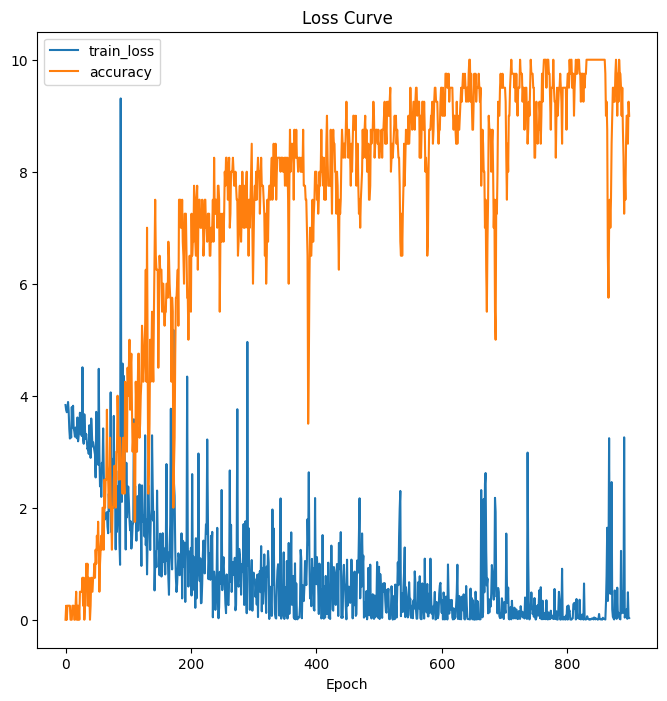

In [185]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.title("Loss Curve")
plt.plot(loss_logger, label='train_loss')
plt.plot(accuracy_logger,label='accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Save and Load Model

In [186]:
pad_sequence(sequences, batch_first=True)

tensor([[[ 0.4926,  0.1945, -1.2354,  ...,  0.5488,  0.1581,  0.0085],
         [ 0.4942,  0.1949, -1.4254,  ...,  0.5481,  0.1576,  0.0085],
         [ 0.4948,  0.1960, -1.4483,  ...,  0.5479,  0.1581,  0.0084],
         ...,
         [ 0.4917,  0.1882, -1.3355,  ...,  0.5458,  0.1536,  0.0126],
         [ 0.4918,  0.1885, -1.3154,  ...,  0.5456,  0.1536,  0.0125],
         [ 0.4918,  0.1886, -1.3147,  ...,  0.5453,  0.1537,  0.0124]],

        [[ 0.4828,  0.2604, -1.2334,  ...,  0.5483,  0.2258,  0.0073],
         [ 0.4816,  0.2606, -1.4555,  ...,  0.5474,  0.2267,  0.0087],
         [ 0.4809,  0.2608, -1.4653,  ...,  0.5475,  0.2266,  0.0088],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.5051,  0.2347, -1.4390,  ...,  0.5717,  0.2094,  0.0091],
         [ 0.5024,  0.2389, -1.5627,  ...,  0

In [187]:
# Put the model in evaluation mode
model.eval()

# No need to track gradients during inference
with torch.no_grad():
    # Get the model's output (logits)
    outputs = model(padded_sequences.to(device))

# outputs = torch.softmax(outputs, dim=1)
# outputs = torch.max(outputs,1)

outputs


tensor([[ 13.4496,  -7.2260, -14.8576,  ..., -19.8868,   6.6438,  -4.2219],
        [ -8.7215,  23.3395, -16.4504,  ...,  10.0835, -19.4497, -12.2901],
        [ -8.7685,   3.8143,  28.2602,  ...,  -2.3879,  -9.7665,   3.9817],
        ...,
        [-15.7498,  12.5401, -20.2498,  ...,  32.0454, -24.0659,   8.3257],
        [ 11.5046,  -5.8887, -12.1786,  ..., -22.1270,  20.0571,  -9.6304],
        [  4.2252, -26.7240,   2.9994,  ...,  -9.7900,   0.6240,  23.9765]],
       device='cuda:0')

In [188]:
padded_sequences

tensor([[[ 0.5013,  0.2452, -1.2167,  ...,  0.5663,  0.2188,  0.0098],
         [ 0.4997,  0.2482, -1.4690,  ...,  0.5652,  0.2181,  0.0106],
         [ 0.4984,  0.2500, -1.4853,  ...,  0.5654,  0.2185,  0.0112],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.4922,  0.2382, -1.2850,  ...,  0.5578,  0.2124,  0.0094],
         [ 0.4920,  0.2405, -1.4288,  ...,  0.5571,  0.2116,  0.0099],
         [ 0.4920,  0.2409, -1.4093,  ...,  0.5567,  0.2122,  0.0098],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.5049,  0.2371, -1.2115,  ...,  0.5643,  0.2082,  0.0088],
         [ 0.5045,  0.2381, -1.1896,  ...,  0

In [189]:
file_paths = ["Data for different actions/เขิน_0.mp4/เขิน_0.npy"]

In [190]:
# Load the sequences
import torch
sequences = load_keypoint_sequences(file_paths)
# Change list to numpy array 
sequences = np.array(sequences)
# Change numpy array to tensor
sequences = torch.FloatTensor(sequences)
sequences = pad_sequence(sequences, batch_first=True)
sequences

tensor([[[ 0.4321,  0.2240, -1.4261,  ...,  0.4724,  0.1833,  0.0108],
         [ 0.4325,  0.2250, -1.4727,  ...,  0.4722,  0.1847,  0.0102],
         [ 0.4330,  0.2258, -1.4930,  ...,  0.4725,  0.1845,  0.0109],
         ...,
         [ 0.4396,  0.2238, -1.5889,  ...,  0.4802,  0.1780,  0.0139],
         [ 0.4395,  0.2238, -1.5796,  ...,  0.4802,  0.1776,  0.0141],
         [ 0.4394,  0.2234, -1.5304,  ...,  0.4799,  0.1771,  0.0144]]])

In [191]:
outputs = model(sequences.to(device))
outputs

tensor([[  7.5823,   0.3613, -19.9278,  -6.2863, -21.7236,   4.8139, -11.4924,
           5.2065,  -9.3429,  -2.8338,  -2.5934,  -1.9949,   6.4344,  -5.0653,
          -4.0501,  -7.7373,   5.0221,  -2.0814, -14.2553,   3.0559, -14.9440,
         -11.7800,  -9.3077,  -3.2981,   2.3669,  -3.5013,  -1.1654,  -0.4708,
          -2.1079,   8.9268, -13.5628,   5.2018,  -5.0090,  -2.0148,  -3.4905,
          10.2788,   2.6378,  -7.8567,  -1.1117,  -4.4926]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [192]:
labels = [action.split(".")[0] for action in actions]
labels

['กฎกระทรวง',
 'กฎหมายรัฐธรรมนูญ',
 'กรมอนามัย',
 'กรรม',
 'กรรมสิทธิ์',
 'กระโดด',
 'กล้วยบวชชี',
 'กล้วยเชื่อม',
 'กังวล',
 'กีฬา',
 'น้อง',
 'เขิน',
 'เขื่อนดิน',
 'เขื่อนสิริกิติ์',
 'เข้าใจผิด',
 'เคย',
 'เครียด',
 'เครื่องปั่นดิน',
 'เครื่องหมายการค้า',
 'เจอ',
 'เจ้าหนี้',
 'เช่าซื้อ',
 'เช่าทรัพย์',
 'เซอร์เบีย',
 'เซเนกัล',
 'เซ็ง',
 'เดิน',
 'เดิมพัน',
 'เพลีย',
 'เมื่อย',
 'เม็กซิโก',
 'เฮโรอีน',
 'แกมเบีย',
 'แซมเบีย',
 'โกหก',
 'โจทก์',
 'โชจู',
 'ใกล้',
 'ไดโนเสาร์',
 'ไอซ์']

In [193]:
# Change from tensor to numpy arrat
outputs = outputs.cpu().detach().numpy()

In [194]:
outputs

array([[  7.58235   ,   0.36126336, -19.927765  ,  -6.286277  ,
        -21.723566  ,   4.8138638 , -11.492439  ,   5.2064967 ,
         -9.34289   ,  -2.8337653 ,  -2.5934296 ,  -1.9948897 ,
          6.434372  ,  -5.065332  ,  -4.0501328 ,  -7.7373304 ,
          5.0220885 ,  -2.081383  , -14.255286  ,   3.055937  ,
        -14.944012  , -11.780033  ,  -9.307734  ,  -3.298115  ,
          2.3668766 ,  -3.5013237 ,  -1.1654106 ,  -0.47082248,
         -2.1079023 ,   8.926817  , -13.562763  ,   5.2018304 ,
         -5.008995  ,  -2.014824  ,  -3.4905324 ,  10.278809  ,
          2.6378357 ,  -7.856713  ,  -1.111718  ,  -4.4925623 ]],
      dtype=float32)

In [195]:
for idx, word in enumerate(outputs):
    # max_value = torch.max(outputs)
    list_outputs = max(outputs)
    print(list_outputs)
    # print(max_value)
    # print(max_value.detach().numpy())

[  7.58235      0.36126336 -19.927765    -6.286277   -21.723566
   4.8138638  -11.492439     5.2064967   -9.34289     -2.8337653
  -2.5934296   -1.9948897    6.434372    -5.065332    -4.0501328
  -7.7373304    5.0220885   -2.081383   -14.255286     3.055937
 -14.944012   -11.780033    -9.307734    -3.298115     2.3668766
  -3.5013237   -1.1654106   -0.47082248  -2.1079023    8.926817
 -13.562763     5.2018304   -5.008995    -2.014824    -3.4905324
  10.278809     2.6378357   -7.856713    -1.111718    -4.4925623 ]


In [196]:
index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)
index_max

35

In [197]:
print(labels[index_max])

โจทก์


In [198]:
correct = 0
num_clip = 0
for clip in labels:
    # print(clip)
    file_paths = [f"Data for different actions/{clip}.mp4/{clip}.npy"]
    # print(file_paths)

    sequences = load_keypoint_sequences(file_paths)
    # Change list to numpy array 
    sequences = np.array(sequences)
    # Change numpy array to tensor
    sequences = torch.FloatTensor(sequences)
    sequences = pad_sequence(sequences, batch_first=True)

    outputs = model(sequences.to(device))

    for idx, word in enumerate(outputs):
        # max_value = torch.max(outputs)
        list_outputs = max(outputs)

    index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)

    print(f"Input : {clip} Predicted : {labels[index_max]}")

    if clip == labels[index_max]:
        correct = correct+1
    
    num_clip = num_clip + 1 

print(f"Correct Predicted on Training set : {correct} Corrct percentage : {correct*100/num_clip}%")

Input : กฎกระทรวง Predicted : กฎกระทรวง
Input : กฎหมายรัฐธรรมนูญ Predicted : กฎหมายรัฐธรรมนูญ
Input : กรมอนามัย Predicted : กรมอนามัย
Input : กรรม Predicted : กังวล
Input : กรรมสิทธิ์ Predicted : กรรมสิทธิ์
Input : กระโดด Predicted : กระโดด
Input : กล้วยบวชชี Predicted : กล้วยบวชชี
Input : กล้วยเชื่อม Predicted : กล้วยเชื่อม
Input : กังวล Predicted : กังวล
Input : กีฬา Predicted : กีฬา
Input : น้อง Predicted : น้อง
Input : เขิน Predicted : เขิน
Input : เขื่อนดิน Predicted : เขื่อนดิน
Input : เขื่อนสิริกิติ์ Predicted : เขื่อนสิริกิติ์
Input : เข้าใจผิด Predicted : กังวล
Input : เคย Predicted : กล้วยเชื่อม
Input : เครียด Predicted : เครียด
Input : เครื่องปั่นดิน Predicted : เครื่องปั่นดิน
Input : เครื่องหมายการค้า Predicted : เครื่องหมายการค้า
Input : เจอ Predicted : เจอ
Input : เจ้าหนี้ Predicted : เจ้าหนี้
Input : เช่าซื้อ Predicted : เช่าซื้อ
Input : เช่าทรัพย์ Predicted : เช่าทรัพย์
Input : เซอร์เบีย Predicted : เซอร์เบีย
Input : เซเนกัล Predicted : เซเนกัล
Input : เซ็ง Predicted : 

In [199]:
print(labels)

['กฎกระทรวง', 'กฎหมายรัฐธรรมนูญ', 'กรมอนามัย', 'กรรม', 'กรรมสิทธิ์', 'กระโดด', 'กล้วยบวชชี', 'กล้วยเชื่อม', 'กังวล', 'กีฬา', 'น้อง', 'เขิน', 'เขื่อนดิน', 'เขื่อนสิริกิติ์', 'เข้าใจผิด', 'เคย', 'เครียด', 'เครื่องปั่นดิน', 'เครื่องหมายการค้า', 'เจอ', 'เจ้าหนี้', 'เช่าซื้อ', 'เช่าทรัพย์', 'เซอร์เบีย', 'เซเนกัล', 'เซ็ง', 'เดิน', 'เดิมพัน', 'เพลีย', 'เมื่อย', 'เม็กซิโก', 'เฮโรอีน', 'แกมเบีย', 'แซมเบีย', 'โกหก', 'โจทก์', 'โชจู', 'ใกล้', 'ไดโนเสาร์', 'ไอซ์']


In [200]:
import os 
video_dir = "C:/Users/araya/Desktop/augments"
video_list = []
video_list = os.listdir(video_dir)

len(video_list)

80

In [201]:
# Path for exported data, numpy arrays
Model_Data=os.path.join('../MediaPipe/Test')

actions_test = np.array(video_list)

no_of_seqs = 1

# 30 frames in length
seq_length = 160

In [202]:
labels_test = [action.split(".")[0] for action in actions_test]
labels_test

['กฎกระทรวง_0',
 'กฎกระทรวง_1',
 'กฎหมายรัฐธรรมนูญ_0',
 'กฎหมายรัฐธรรมนูญ_1',
 'กรมอนามัย_0',
 'กรมอนามัย_1',
 'กรรม_0',
 'กรรม_1',
 'กรรมสิทธิ์_0',
 'กรรมสิทธิ์_1',
 'กระโดด_0',
 'กระโดด_1',
 'กล้วยบวชชี_0',
 'กล้วยบวชชี_1',
 'กล้วยเชื่อม_0',
 'กล้วยเชื่อม_1',
 'กังวล_0',
 'กังวล_1',
 'กีฬา_0',
 'กีฬา_1',
 'น้อง_0',
 'น้อง_1',
 'เขิน_0',
 'เขิน_1',
 'เขื่อนดิน_0',
 'เขื่อนดิน_1',
 'เขื่อนสิริกิติ์_0',
 'เขื่อนสิริกิติ์_1',
 'เข้าใจผิด_0',
 'เข้าใจผิด_1',
 'เคย_0',
 'เคย_1',
 'เครียด_0',
 'เครียด_1',
 'เครื่องปั่นดิน_0',
 'เครื่องปั่นดิน_1',
 'เครื่องหมายการค้า_0',
 'เครื่องหมายการค้า_1',
 'เจอ_0',
 'เจอ_1',
 'เจ้าหนี้_0',
 'เจ้าหนี้_1',
 'เช่าซื้อ_0',
 'เช่าซื้อ_1',
 'เช่าทรัพย์_0',
 'เช่าทรัพย์_1',
 'เซอร์เบีย_0',
 'เซอร์เบีย_1',
 'เซเนกัล_0',
 'เซเนกัล_1',
 'เซ็ง_0',
 'เซ็ง_1',
 'เดิน_0',
 'เดิน_1',
 'เดิมพัน_0',
 'เดิมพัน_1',
 'เพลีย_0',
 'เพลีย_1',
 'เมื่อย_0',
 'เมื่อย_1',
 'เม็กซิโก_0',
 'เม็กซิโก_1',
 'เฮโรอีน_0',
 'เฮโรอีน_1',
 'แกมเบีย_0',
 'แกมเบีย_1',
 'แซมเบีย_0',
 'แซมเบี

In [203]:
file_paths = []
for action in actions_test:
    video_path = os.path.join('Test/', action)
    # print(video_path)
    # print(action)
    file_paths.append(video_path + '/' + action.split(".")[0] + ".npy")
print(file_paths)

['Test/กฎกระทรวง_0.mp4/กฎกระทรวง_0.npy', 'Test/กฎกระทรวง_1.mp4/กฎกระทรวง_1.npy', 'Test/กฎหมายรัฐธรรมนูญ_0.mp4/กฎหมายรัฐธรรมนูญ_0.npy', 'Test/กฎหมายรัฐธรรมนูญ_1.mp4/กฎหมายรัฐธรรมนูญ_1.npy', 'Test/กรมอนามัย_0.mp4/กรมอนามัย_0.npy', 'Test/กรมอนามัย_1.mp4/กรมอนามัย_1.npy', 'Test/กรรม_0.mp4/กรรม_0.npy', 'Test/กรรม_1.mp4/กรรม_1.npy', 'Test/กรรมสิทธิ์_0.mp4/กรรมสิทธิ์_0.npy', 'Test/กรรมสิทธิ์_1.mp4/กรรมสิทธิ์_1.npy', 'Test/กระโดด_0.mp4/กระโดด_0.npy', 'Test/กระโดด_1.mp4/กระโดด_1.npy', 'Test/กล้วยบวชชี_0.mp4/กล้วยบวชชี_0.npy', 'Test/กล้วยบวชชี_1.mp4/กล้วยบวชชี_1.npy', 'Test/กล้วยเชื่อม_0.mp4/กล้วยเชื่อม_0.npy', 'Test/กล้วยเชื่อม_1.mp4/กล้วยเชื่อม_1.npy', 'Test/กังวล_0.mp4/กังวล_0.npy', 'Test/กังวล_1.mp4/กังวล_1.npy', 'Test/กีฬา_0.mp4/กีฬา_0.npy', 'Test/กีฬา_1.mp4/กีฬา_1.npy', 'Test/น้อง_0.mp4/น้อง_0.npy', 'Test/น้อง_1.mp4/น้อง_1.npy', 'Test/เขิน_0.mp4/เขิน_0.npy', 'Test/เขิน_1.mp4/เขิน_1.npy', 'Test/เขื่อนดิน_0.mp4/เขื่อนดิน_0.npy', 'Test/เขื่อนดิน_1.mp4/เขื่อนดิน_1.npy', 'Test/เขื่อนสิริกิติ์_0

In [204]:
correct = 0
num_clip = 0
for clip in labels_test:
    # print(clip)
    file_paths = [f"Test/{clip}.mp4/{clip}.npy"]
    # print(file_paths)

    sequences = load_keypoint_sequences(file_paths)
    # Change list to numpy array 
    sequences = np.array(sequences)
    # Change numpy array to tensor
    sequences = torch.FloatTensor(sequences)
    sequences = pad_sequence(sequences, batch_first=True)

    outputs = model(sequences.to(device))

    for idx, word in enumerate(outputs):
        # max_value = torch.max(outputs)
        list_outputs = max(outputs)

    index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)

    print(f"Input : {clip} Predicted : {labels[index_max]}")

    if clip == labels[index_max]:
        correct = correct+1
    
    num_clip = num_clip + 1 

print(f"Correct Predicted on Training set : {correct} Corrct percentage : {correct*100/num_clip}%")

Input : กฎกระทรวง_0 Predicted : กฎกระทรวง
Input : กฎกระทรวง_1 Predicted : กฎกระทรวง
Input : กฎหมายรัฐธรรมนูญ_0 Predicted : กฎหมายรัฐธรรมนูญ
Input : กฎหมายรัฐธรรมนูญ_1 Predicted : กฎหมายรัฐธรรมนูญ
Input : กรมอนามัย_0 Predicted : เขื่อนสิริกิติ์
Input : กรมอนามัย_1 Predicted : กรมอนามัย
Input : กรรม_0 Predicted : แซมเบีย
Input : กรรม_1 Predicted : กังวล
Input : กรรมสิทธิ์_0 Predicted : กรรมสิทธิ์
Input : กรรมสิทธิ์_1 Predicted : กรรมสิทธิ์
Input : กระโดด_0 Predicted : โชจู
Input : กระโดด_1 Predicted : กระโดด
Input : กล้วยบวชชี_0 Predicted : เช่าซื้อ
Input : กล้วยบวชชี_1 Predicted : เช่าซื้อ
Input : กล้วยเชื่อม_0 Predicted : กล้วยเชื่อม
Input : กล้วยเชื่อม_1 Predicted : กล้วยเชื่อม
Input : กังวล_0 Predicted : เซเนกัล
Input : กังวล_1 Predicted : กังวล
Input : กีฬา_0 Predicted : กรมอนามัย
Input : กีฬา_1 Predicted : กรมอนามัย
Input : น้อง_0 Predicted : เดิน
Input : น้อง_1 Predicted : น้อง
Input : เขิน_0 Predicted : โจทก์
Input : เขิน_1 Predicted : เขิน
Input : เขื่อนดิน_0 Predicted : เขื่อนด

### Save Model

In [205]:
torch.save(model.state_dict(), 'saved_data/attention_lstm.pt')
torch.save(optimizer.state_dict(), 'saved_data/optimizer.pt')
# torch.save(scheduler.state_dict(), 'saved_data/scheduler.pt')

### Real-Time Prediction

In [206]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp 

In [207]:
mp_holist = mp.solutions.holistic 
mp_draw = mp.solutions.drawing_utils

In [208]:
def mediapipe_detection(img, model):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img.flags.writeable = False                 
    result = model.process(img)                 # Make prediction
    img.flags.writeable = True                   
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
    return img, result

In [209]:
def draw_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS) # Draw face connections
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS) # Draw pose connections
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw left hand connections
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw right hand connections

In [210]:
def draw_styled_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
                             mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
                             mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
                             ) 
    # mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
    #                          mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
    #                          mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
    #                          ) 
    
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS,
                             mp_draw.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [211]:
def extract_keypoints(results):
    pose=np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    left_hnd=np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hnd=np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face=np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    return np.concatenate([pose,left_hnd,right_hnd,face])
# concatenating for the model to detect the sign language

In [221]:
# Initialize MediaPipe holistic model
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic()

# Initialize OpenCV video capture
cap = cv2.VideoCapture(0)

sequence = []
sequence_length = 160

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert the image to RGB (MediaPipe expects RGB images)
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Process the frame with MediaPipe
    results = holistic.process(image_rgb)
    
    # Extract keypoints (face, hands, and pose landmarks)
    # Assume extract_keypoints function converts keypoints into a flattened vector of size 1662
    keypoints = extract_keypoints(results) 
    
    # Append keypoints to the sequence buffer
    sequence.append(keypoints)
    
    # Ensure the sequence only keeps the last 160 frames
    if len(sequence) > sequence_length:
        sequence.pop(0)
    
    if len(sequence) == sequence_length:
        # Convert sequence to tensor
        input_tensor = torch.tensor([sequence], dtype=torch.float32)
        
        # Make predictions
        with torch.no_grad():
            prediction = model(input_tensor.to(device))
        
        # Decode and display the prediction
        predicted_class = torch.argmax(prediction, dim=1).item()
        print(f"Predicted Class: {predicted_class}")
    
    # Display the video frame
    cv2.imshow('Real-time Sign Language Recognition', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Class: 4
Predicted Cl

In [220]:
cap.release()
cv2.destroyAllWindows()

### Save & Load Model Command

In [ ]:
# torch.save(model.state_dict(), 'saved_data/attention_lstm.pt')
# torch.save(optimizer.state_dict(), 'saved_data/optimizer.pt')
# # torch.save(scheduler.state_dict(), 'saved_data/scheduler.pt')

In [ ]:
# #Load model
# model.load_state_dict(torch.load('saved_data/model_name.pt'))
# optimizer.load_state_dict(torch.load('saved_data/optimizer_namae.pt'))